In [1]:
import warnings
warnings.filterwarnings("ignore")

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

# Содержание
1. Скачивание и обработка данных
    - Для простоты уменьшаем количество данных, переходим от часовых показателей к ежедневным
    - Преобразуем данные так, чтобы индексом была дата (а не просто число), а для каждого момента времени по столбцам были указаны рассматриваемые криптовалюты
    - Некоторые криптовалюты имеют слишком мало данных, удаляем их из рассмотрения, список сокращается до 29 криптовалют
    - Удаляем строки с данными, в которых есть пропуски (те даты, в которые не торговалась хотя бы одна из валют)
    - Будем рассматривать только криптовалюты с наибольшей доходностью, список сокращен до 5 криптовалют
    - Итогом данных операций является таблица D


2. Постороение фичей
    - Используем SMA (ex. f_open7), агрегированные индексы (срелний и средневзвешанный)
    - Строим матрицу корреляций


3. Построение модели для предсказания цены каждой из выбранных криптовалют
    - Используется RandomForestRegressor
    - Предсказываем доходность на основе 8 индивидуальных фичей, а также 2х агрегированных индексов
    - Используется Shift, чтобы не предсказывать цены на основе фичей на основе предсказываемых доходностей
    - Считаем скоры (0 - плохое предсказание, <0 - ужасное предсказание). Заметим, что у полученных все скоры на test положительны, что дает надежду о качестве построенных моделей
    - Создаем столбец с предсказанием для каждой криптовалюты
    - Получаем итоговую таблицу E, в которой можно сравнить факт с предсказанием
    - Получаем итоговую таблицу predicted_prices, в которой содержатся предсказанные цены. На основе этих предсказаний будем делать портфель.



4. Modern Portfolio Theory.
    - Портфель обновляется раз в месяц
    - Подбираем веса портфеля так, чтобы месячный коэфффициент Шарпа был максимален
    - Perfomance - показатели перфоманса полученнго портфеля (коэффициент Шарпа, веса, доходность, волатильность)
    

## Скачиваем и обрабатываем данные

In [3]:
df = pd.read_csv('./market_data_train.csv')
df

,symbol,time,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume
0,1INCH,2020-12-25 06:00:00,0.2000,3.0885,0.2000,2.5826,6.707592e+07,48768,3.553052e+07,1.724763e+07
1,1INCH,2020-12-25 07:00:00,2.5824,2.6900,2.2249,2.5059,6.508385e+07,31099,2.244087e+07,9.861481e+06
2,1INCH,2020-12-25 08:00:00,2.5152,2.8870,2.3609,2.6237,6.814338e+07,33001,2.130043e+07,1.160785e+07
3,1INCH,2020-12-25 09:00:00,2.6318,2.8247,2.4650,2.6134,6.787587e+07,30459,1.749181e+07,9.087566e+06
4,1INCH,2020-12-25 10:00:00,2.6104,2.7498,2.5629,2.6365,6.847583e+07,21023,9.919400e+06,4.798067e+06
...,...,...,...,...,...,...,...,...,...,...
2235079,ZRX,2021-05-31 16:00:00,0.9755,1.0160,0.9731,1.0149,8.544659e+08,1745,5.283764e+05,2.847624e+05
2235080,ZRX,2021-05-31 17:00:00,1.0147,1.0200,0.9871,1.0047,8.458783e+08,1451,3.980687e+05,1.617346e+05
2235081,ZRX,2021-05-31 18:00:00,1.0064,1.0077,0.9830,0.9884,8.321549e+08,894,2.268356e+05,7.276305e+04
2235082,ZRX,2021-05-31 19:00:00,0.9889,0.9905,0.9827,0.9865,8.305553e+08,346,7.615435e+04,3.804757e+04


Создадим новый столбец, который будет включать в себя только дату (без времени суток)

In [4]:
import datetime
df['only_date'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').date() for d in df['time']]

In [5]:
df

,symbol,time,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume,only_date
0,1INCH,2020-12-25 06:00:00,0.2000,3.0885,0.2000,2.5826,6.707592e+07,48768,3.553052e+07,1.724763e+07,2020-12-25
1,1INCH,2020-12-25 07:00:00,2.5824,2.6900,2.2249,2.5059,6.508385e+07,31099,2.244087e+07,9.861481e+06,2020-12-25
2,1INCH,2020-12-25 08:00:00,2.5152,2.8870,2.3609,2.6237,6.814338e+07,33001,2.130043e+07,1.160785e+07,2020-12-25
3,1INCH,2020-12-25 09:00:00,2.6318,2.8247,2.4650,2.6134,6.787587e+07,30459,1.749181e+07,9.087566e+06,2020-12-25
4,1INCH,2020-12-25 10:00:00,2.6104,2.7498,2.5629,2.6365,6.847583e+07,21023,9.919400e+06,4.798067e+06,2020-12-25
...,...,...,...,...,...,...,...,...,...,...,...
2235079,ZRX,2021-05-31 16:00:00,0.9755,1.0160,0.9731,1.0149,8.544659e+08,1745,5.283764e+05,2.847624e+05,2021-05-31
2235080,ZRX,2021-05-31 17:00:00,1.0147,1.0200,0.9871,1.0047,8.458783e+08,1451,3.980687e+05,1.617346e+05,2021-05-31
2235081,ZRX,2021-05-31 18:00:00,1.0064,1.0077,0.9830,0.9884,8.321549e+08,894,2.268356e+05,7.276305e+04,2021-05-31
2235082,ZRX,2021-05-31 19:00:00,0.9889,0.9905,0.9827,0.9865,8.305553e+08,346,7.615435e+04,3.804757e+04,2021-05-31


Создадим новую таблицу A, которая будет иметь агрегированные данные за день, используя groupby для каждой бумаги и даты

In [6]:
A = pd.DataFrame()
temp_open = df.copy()
temp_open = temp_open.groupby(['symbol', 'only_date']).first()['open']
temp_high = df.copy()
temp_high = temp_high.groupby(['symbol', 'only_date']).max()['high']
temp_low = df.copy()
temp_low = temp_low.groupby(['symbol', 'only_date']).min()['low']
temp_close = df.copy()
temp_close = temp_close.groupby(['symbol', 'only_date']).last()['close']
temp_mc = df.copy()
temp_mc = temp_mc.groupby(['symbol', 'only_date']).sum()['market_cap']
temp_tr = df.copy()
temp_tr = temp_tr.groupby(['symbol', 'only_date']).sum()['n_trades']
temp_vol = df.copy()
temp_vol = temp_vol.groupby(['symbol', 'only_date']).sum()['volume']
temp_tbv = df.copy()
temp_tbv = temp_tbv.groupby(['symbol', 'only_date']).sum()['taker_buy_volume']
A['open'] = temp_open
A['high'] = temp_high
A['low'] = temp_low
A['close'] = temp_close
A['market_cap'] = temp_mc
A['n_trades'] = temp_tr
A['volume'] = temp_vol
A['taker_buy_volume'] = temp_tbv
A

open    high     low   close    market_cap  n_trades  \
symbol only_date                                                            
1INCH  2020-12-25  0.2000  3.0885  0.2000  2.1936  1.100153e+09    596566   
       2020-12-26  2.1936  2.4609  1.5717  1.6221  1.141930e+09    314848   
       2020-12-27  1.6206  1.6668  1.0360  1.1001  8.263693e+08    301197   
       2020-12-28  1.1019  1.2787  1.0353  1.0906  1.572571e+09    157507   
       2020-12-29  1.0889  1.1344  0.7541  0.8852  1.556105e+09    164635   
...                   ...     ...     ...     ...           ...       ...   
ZRX    2021-05-27  1.1324  1.1888  1.0225  1.1076  2.262910e+10     36198   
       2021-05-28  1.1078  1.1243  0.9245  0.9421  2.045077e+10     43691   
       2021-05-29  0.9420  1.0089  0.8432  0.8922  1.887528e+10     27272   
       2021-05-30  0.8905  0.9909  0.8421  0.9444  1.893287e+10     22351   
       2021-05-31  0.9431  1.0200  0.8874  0.9988  1.686183e+10     16946   

                         volume  taker_buy_volume  
symbol only_date                                   
1INCH  2020-12-25  2.923449e+08      1.444582e+08  
       2020-12-26  1.132451e+08      5.393879e+07  
       2020-12-27  9.892812e+07      4.747393e+07  
       2020-12-28  4.796362e+07      2.439249e+07  
       2020-12-29  4.745768e+07      2.154755e+07  
...                         ...               ...  
ZRX    2021-05-27  1.049805e+07      5.423639e+06  
       2021-05-28  1.264365e+07      6.685530e+06  
       2021-05-29  6.976375e+06      3.629081e+06  
       2021-05-30  5.166297e+06      2.636999e+06  
       2021-05-31  4.634872e+06      2.241551e+06  

[93597 rows x 8 columns]

In [7]:
B = A.copy() #чтобы не проигрывать код в предыдущей строке много раз

In [8]:
B = pd.DataFrame(B)
B['symbol'] = [i[0] for i in list(B.index[:])]
B['date'] = [i[1] for i in list(B.index[:])]
B.index = [i for i in range(93597)]

In [9]:
B['close_pct'] = B['close'].pct_change()
# создаем вспомогательный столбец pnl_without_cumsum
B['pnl_without_cumsum'] = 0
B['pnl_without_cumsum'] = B['close'] - B['close'].shift(1)
B['pnl'] = B['pnl_without_cumsum'].cumsum()
B = B.drop('pnl_without_cumsum', axis = 1)

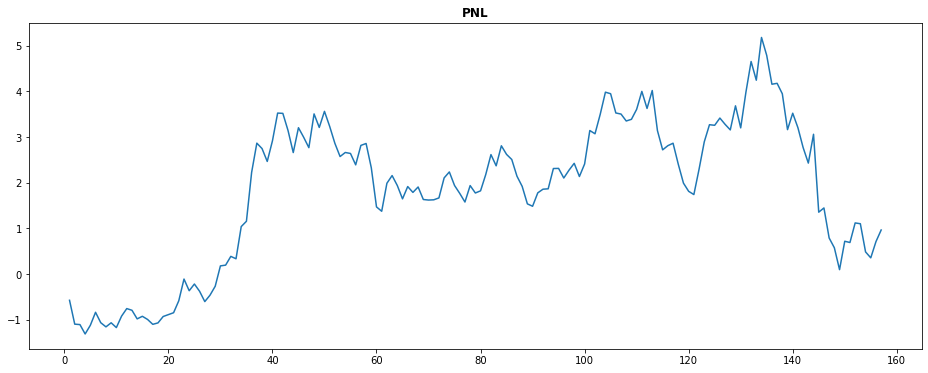

In [10]:
B['pnl'][B.symbol == '1INCH'].plot(figsize=(16, 6))
plt.title("PNL", weight="bold")

plt.show()

In [11]:
# Хотим посмотреть 12 фичей: для 4х типов цен и 3х видов параметров (всего 12)
price_type = ['open', 'high', 'low', 'close']
sma_days = [7, 30]
f_names = []
for p in price_type:
    for h in sma_days:
        name = 'f_' + p + str(h)
        data = B[p]
        rolling_mean = data.rolling(window = h).mean()
        B[name] = B[p]/rolling_mean - 1
        f_names.append(name)

In [12]:
C = B.copy()

In [13]:
# отсортируем по времени
C.sort_values(by = 'date', inplace = True)
date = C.date
C.drop(['date'], axis = 1, inplace = True)
C.index = date
C

,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume,symbol,close_pct,pnl,f_open7,f_open30,f_high7,f_high30,f_low7,f_low30,f_close7,f_close30
date,,,,,,,,,,,,,,,,,,,
2018-01-01,13740.9600,13818.550,12750.0000,13452.0000,5.384947e+12,101686,1.102353e+08,5.080436e+07,BTC,2915.043442,13449.8064,5.986020,28.612534,5.985176,28.592692,5.986036,28.620025,5.985755,28.609428
2018-01-01,8.5299,8.700,7.8000,8.3706,1.963553e+10,19480,5.154648e+06,2.251361e+06,BNB,39.089080,6.1770,5.109200,13.599027,4.998924,13.008248,5.113804,13.922737,5.078527,13.620727
2018-01-01,223.5000,231.190,212.7400,223.9400,2.911334e+11,16653,4.368980e+06,2.090275e+06,LTC,63.987376,221.7464,5.343469,16.168830,5.334278,15.544131,5.386353,16.717614,5.368453,16.277752
2018-01-01,733.9900,763.550,716.8000,754.5800,1.726566e+12,72335,3.847616e+07,1.998742e+07,ETH,10.118347,752.3864,3.420702,5.945890,3.402184,5.470962,3.529939,6.580068,3.506308,6.040821
2018-01-01,74.8530,80.000,71.0500,79.0390,1.168199e+11,10271,5.719370e+06,3.611816e+06,NEO,23.256253,76.8454,4.597795,9.954354,4.590809,9.886171,4.648354,10.346777,4.664498,10.444047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,0.6340,0.666,0.5850,0.6490,5.257224e+08,13293,2.505076e+06,1.266228e+06,DREP,0.025276,-1.5446,0.088813,-0.387045,-0.003420,-0.403618,0.099034,-0.367385,0.081667,-0.350394
2021-05-31,12.9040,13.997,12.1370,13.5700,1.669679e+10,6881,1.560066e+06,7.863127e+05,UMA,0.053817,11.3764,-0.062053,-0.392743,-0.049827,-0.381344,-0.043911,-0.362967,-0.009045,-0.347549
2021-05-31,9.2870,11.225,8.6760,10.9040,8.059109e+08,33587,6.464907e+06,3.381566e+06,UNFI,0.168828,8.7104,-0.103609,-0.476850,-0.047703,-0.415602,-0.056136,-0.447214,0.045675,-0.368222


In [14]:
pearsoncorr = C.corr(method='pearson')
pearsoncorr

,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume,close_pct,pnl,f_open7,f_open30,f_high7,f_high30,f_low7,f_low30,f_close7,f_close30
open,1.000000,0.998225,0.997103,0.997241,0.735572,0.346755,0.460400,0.456430,0.000038,0.997241,0.007906,0.015480,0.006798,0.015038,0.006386,0.014671,0.005910,0.014689
high,0.998225,1.000000,0.995985,0.998640,0.722050,0.342785,0.454526,0.450868,0.001112,0.998640,0.008973,0.017230,0.009003,0.017352,0.008062,0.016674,0.008276,0.017038
low,0.997103,0.995985,1.000000,0.998140,0.749875,0.348958,0.462011,0.458418,0.000031,0.998140,0.007868,0.014710,0.007433,0.014579,0.007903,0.014616,0.007242,0.014520
close,0.997241,0.998640,0.998140,1.000000,0.735126,0.346134,0.458518,0.455038,0.000133,1.000000,0.008008,0.015662,0.008247,0.015833,0.007814,0.015431,0.008194,0.015803
market_cap,0.735572,0.722050,0.749875,0.735126,1.000000,0.531295,0.692404,0.688212,0.000634,0.735126,0.006008,0.011781,0.005787,0.011557,0.005418,0.011405,0.005356,0.011456
n_trades,0.346755,0.342785,0.348958,0.346134,0.531295,1.000000,0.921693,0.924397,0.004331,0.346146,0.078584,0.095552,0.107150,0.117425,0.061977,0.085492,0.087583,0.104687
volume,0.460400,0.454526,0.462011,0.458518,0.692404,0.921693,1.000000,0.999604,0.002102,0.458521,0.046175,0.057265,0.061505,0.070218,0.034785,0.050289,0.050204,0.062515
taker_buy_volume,0.456430,0.450868,0.458418,0.455038,0.688212,0.924397,0.999604,1.000000,0.002016,0.455041,0.046868,0.057937,0.063372,0.071596,0.036130,0.051221,0.052306,0.063919
close_pct,0.000038,0.001112,0.000031,0.000133,0.000634,0.004331,0.002102,0.002016,1.000000,0.000133,0.132536,0.182841,0.130043,0.182556,0.133343,0.183968,0.134674,0.184990
pnl,0.997241,0.998640,0.998140,1.000000,0.735126,0.346146,0.458521,0.455041,0.000133,1.000000,0.008008,0.015662,0.008247,0.015833,0.007814,0.015431,0.008194,0.015803


<AxesSubplot:>

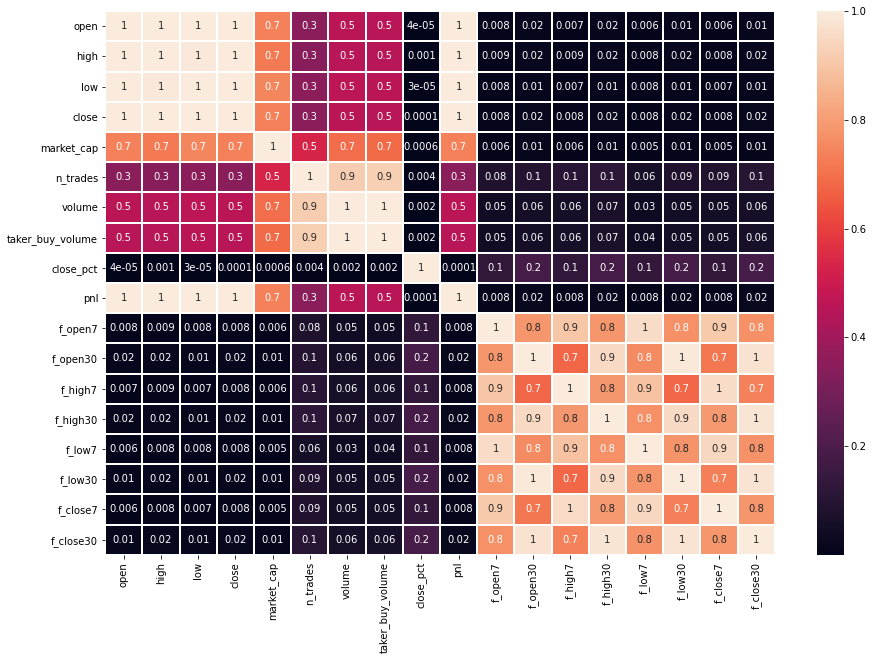

In [15]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
#             cmap='RdBu_r',
            annot=True,
            linewidth=1,
            fmt='.1g')

__________

In [16]:
all_dates = C.index.unique()
all_symbols = C.symbol.unique()
D = pd.DataFrame(index = all_dates)
for i in all_symbols:
    D[i] = C['close'].loc[C['symbol'] == i]

Удалим криптовалюты, по которым мало измерений (<800)

In [17]:
for name in all_symbols:
    if D[name].count() < 800:
        D.drop([name], axis = 1, inplace = True)
D.count()

BTC      1247
BNB      1247
LTC      1247
ETH      1247
NEO      1247
QTUM     1170
ADA      1141
XRP      1124
EOS      1100
IOTA     1097
XLM      1097
ONT      1089
TRX      1086
ETC      1085
ICX      1084
NULS     1044
VET      1042
LINK      867
WAVES     865
BTT       852
ONG       836
HOT       834
ZIL       833
FET       824
ZRX       824
BAT       820
XMR       809
ZEC       803
IOST      802
dtype: int64

In [18]:
D = D.dropna(axis = 0)
D
D2 = D.copy()

In [19]:
D

,BTC,BNB,LTC,ETH,NEO,QTUM,ADA,XRP,EOS,IOTA,...,BTT,ONG,HOT,ZIL,FET,ZRX,BAT,XMR,ZEC,IOST
date,,,,,,,,,,,,,,,,,,,,,
2019-03-22,3990.94,15.1952,59.29,136.11,9.140,2.510,0.05801,0.31021,3.6203,0.3106,...,0.000779,0.6394,0.001194,0.01934,0.20600,0.2703,0.1986,52.93,55.20,0.008569
2019-03-23,3995.35,15.0339,60.67,136.97,9.302,2.661,0.06329,0.31086,3.6567,0.3117,...,0.000802,0.6306,0.001167,0.01957,0.20290,0.2690,0.1998,52.51,56.44,0.008738
2019-03-24,3986.57,17.1997,59.67,135.91,9.075,2.579,0.06043,0.30739,3.6323,0.3064,...,0.000783,0.6231,0.001155,0.01997,0.20550,0.2864,0.2090,52.56,57.07,0.008396
2019-03-25,3936.00,16.6061,59.03,133.98,8.897,2.483,0.05825,0.30300,3.6487,0.2977,...,0.000748,0.5924,0.001112,0.01885,0.19590,0.2769,0.2039,51.15,55.05,0.008129
2019-03-26,3935.08,16.2555,58.27,133.86,8.810,2.462,0.06158,0.29937,3.6544,0.2926,...,0.000746,0.5783,0.001087,0.01842,0.18180,0.2871,0.2147,51.77,54.00,0.008196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,38503.15,367.7300,193.76,2755.60,62.893,14.558,1.65380,0.97500,7.0946,1.1749,...,0.004163,1.0722,0.009546,0.12149,0.29647,1.1076,0.8652,252.13,148.79,0.034478
2021-05-28,35061.65,325.2600,173.64,2388.80,53.362,11.943,1.48530,0.88020,5.9919,1.0178,...,0.003690,1.1233,0.008129,0.10859,0.28747,0.9421,0.7288,254.32,155.02,0.029057
2021-05-29,34467.84,303.9200,163.18,2272.04,50.103,11.159,1.38890,0.82330,5.9614,0.9772,...,0.003519,1.0188,0.008180,0.09832,0.28181,0.8922,0.6762,241.59,146.70,0.029153


# Построение фичей

In [20]:
all_dates = D.index.unique()
all_symbols = D.columns.unique()
X = pd.DataFrame(index = all_dates)
features_names = []
target_names = []
for i in all_symbols:
    X[i + '_close'] = C['close'].loc[C['symbol'] == i]
    X[i + '_MC'] = C['market_cap'].loc[C['symbol'] == i]
    X[i + '_pnl'] = C['pnl'].loc[C['symbol'] == i]
    X[i + '_r'] = C['close_pct'].loc[C['symbol'] == i]
    target_names.append(i + '_r')
    for j in f_names:
        X[i + j] = C[j].loc[C['symbol'] == i]
        features_names.append(i+j)

In [21]:
# агрегированные индексы
X['aggregate_i_w'] = 0
X['aggregate_i'] = 0
X['MC_total'] = 0
X['Defined'] = X.count(axis = 1)
X = X.fillna(0)
for i in all_symbols:
    X['aggregate_i_w'] = X['aggregate_i_w'] + X[i + '_r'] * X[i + '_MC']
    X['aggregate_i'] = X['aggregate_i'] + X[i + '_r']
    X['MC_total'] = X['MC_total'] + X[i + '_MC']
X['aggregate_i_w'] = X['aggregate_i_w'] / X['MC_total']
X['aggregate_i'] = X['aggregate_i'] / X['Defined']
X = X.drop(['MC_total', 'Defined'], axis = 1)
features_names.append('aggregate_i_w')
features_names.append('aggregate_i')
# print(features_names)

In [22]:
X

,BTC_close,BTC_MC,BTC_pnl,BTC_r,BTCf_open7,BTCf_open30,BTCf_high7,BTCf_high30,BTCf_low7,BTCf_low30,...,IOSTf_open7,IOSTf_open30,IOSTf_high7,IOSTf_high30,IOSTf_low7,IOSTf_low30,IOSTf_close7,IOSTf_close30,aggregate_i_w,aggregate_i
date,,,,,,,,,,,,,,,,,,,,,
2019-03-22,3990.94,1.685293e+12,3988.7464,0.002192,-0.001942,0.022329,-0.007370,0.014060,0.005844,0.034033,...,-0.996261,-0.997858,-0.996606,-0.998060,-0.998829,-0.999314,-0.998924,-0.999373,0.005715,-0.000736
2019-03-23,3995.35,1.688629e+12,3993.1564,0.001105,-0.002440,0.024297,-0.003342,0.016780,0.005996,0.035884,...,-0.998714,-0.999358,-0.998773,-0.999398,-0.998589,-0.999289,-0.998642,-0.999328,0.004626,0.000716
2019-03-24,3986.57,1.686013e+12,3984.3764,-0.002198,-0.000988,0.024763,-0.005909,0.013845,-0.001087,0.028304,...,-0.998298,-0.999312,-0.998403,-0.999366,-0.998170,-0.999255,-0.998294,-0.999323,-0.003294,-0.000188
2019-03-25,3936.00,1.678654e+12,3933.8064,-0.012685,-0.003222,0.022321,-0.006715,0.013059,-0.014286,0.012739,...,-0.997679,-0.999306,-0.997854,-0.999359,-0.997631,-0.999251,-0.997798,-0.999309,-0.014495,-0.002218
2019-03-26,3935.08,1.661669e+12,3932.8864,-0.000234,-0.013869,0.010965,-0.014210,0.004874,-0.010221,0.012523,...,-0.996596,-0.999290,-0.996800,-0.999334,-0.996495,-0.999217,-0.996774,-0.999266,-0.001924,-0.000598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,38503.15,1.742472e+13,38500.9564,-0.011671,0.027687,-0.210551,0.009328,-0.209610,0.061078,-0.202411,...,0.058474,-0.332979,-0.037325,-0.357603,0.116170,-0.319987,0.070655,-0.317079,-0.019226,-0.002107
2021-05-28,35061.65,1.644770e+13,35059.4564,-0.089382,0.027109,-0.211002,-0.017320,-0.230799,-0.013751,-0.244695,...,0.071151,-0.317178,-0.019156,-0.354509,-0.004311,-0.380103,-0.085453,-0.412471,-0.103427,-0.008853
2021-05-29,34467.84,1.585517e+13,34465.6464,-0.016936,-0.058944,-0.271867,-0.051119,-0.252449,-0.037514,-0.257510,...,-0.083066,-0.411316,-0.082141,-0.403568,-0.012599,-0.383021,-0.068684,-0.397676,-0.033065,-0.004135


## ML модели для предсказания цен криптовалют

In [23]:
targets = X[target_names]
features = X[features_names]

In [24]:
# targets

In [25]:
# features

In [26]:
# # разделили dataset на 2 части: тренировачный (85%) и тестовый
# import statsmodels.api as sm
# train_size = int(0.85 * targets.shape[0])
# train_features = features[:train_size]
# train_targets = targets[:train_size]
# test_features = features[train_size:]
# test_targets = targets[train_size:]

In [27]:
# разделили dataset на 2 части: тренировачный (85%) и тестовый
import statsmodels.api as sm
train_size = int(0.85 * targets.shape[0])
train_features = features[:train_size].shift(1).dropna() #смещение на 1, так как иначе используем фичи, которые построены на основе цен, которые пытаемся предсказать
train_targets = targets[:train_size-1]
test_features = features[train_size:].shift(1).dropna()
test_targets = targets[train_size:-1]

In [28]:
train_features

,BTCf_open7,BTCf_open30,BTCf_high7,BTCf_high30,BTCf_low7,BTCf_low30,BTCf_close7,BTCf_close30,BNBf_open7,BNBf_open30,...,IOSTf_open7,IOSTf_open30,IOSTf_high7,IOSTf_high30,IOSTf_low7,IOSTf_low30,IOSTf_close7,IOSTf_close30,aggregate_i_w,aggregate_i
date,,,,,,,,,,,,,,,,,,,,,
2019-03-23,-0.001942,0.022329,-0.007370,0.014060,0.005844,0.034033,-0.002417,0.024313,-0.056258,0.108701,...,-0.996261,-0.997858,-0.996606,-0.998060,-0.998829,-0.999314,-0.998924,-0.999373,0.005715,-0.000736
2019-03-24,-0.002440,0.024297,-0.003342,0.016780,0.005996,0.035884,-0.001010,0.024771,-0.008223,0.154527,...,-0.998714,-0.999358,-0.998773,-0.999398,-0.998589,-0.999289,-0.998642,-0.999328,0.004626,0.000716
2019-03-25,-0.000988,0.024763,-0.005909,0.013845,-0.001087,0.028304,-0.003227,0.022367,-0.010317,0.128934,...,-0.998298,-0.999312,-0.998403,-0.999366,-0.998170,-0.999255,-0.998294,-0.999323,-0.003294,-0.000188
2019-03-26,-0.003222,0.022321,-0.006715,0.013059,-0.014286,0.012739,-0.013898,0.010979,0.116100,0.271004,...,-0.997679,-0.999306,-0.997854,-0.999359,-0.997631,-0.999251,-0.997798,-0.999309,-0.014495,-0.002218
2019-03-27,-0.013869,0.010965,-0.014210,0.004874,-0.010221,0.012523,-0.011550,0.009308,0.066800,0.209467,...,-0.996596,-0.999290,-0.996800,-0.999334,-0.996495,-0.999217,-0.996774,-0.999266,-0.001924,-0.000598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26,-0.047002,-0.044723,-0.005484,-0.012351,0.003806,0.005444,-0.020433,-0.040513,0.002498,0.037248,...,0.019165,0.542407,-0.008079,0.429400,0.063332,0.605499,-0.000300,0.433924,0.000362,-0.001992
2021-01-27,-0.020437,-0.040532,-0.044322,-0.074191,-0.006887,-0.033568,0.004644,-0.038376,0.004233,0.018912,...,-0.000343,0.433867,-0.041257,0.300674,0.005108,0.434601,0.041549,0.432551,0.010271,0.000723
2021-01-28,0.004639,-0.038395,-0.026176,-0.076233,-0.039907,-0.086572,-0.044728,-0.106588,0.014393,0.018078,...,0.041526,0.432738,-0.023938,0.272407,0.035120,0.424094,-0.023553,0.283342,-0.070469,-0.005544


In [29]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor(max_depth=6)

In [30]:
for i in range(len(D.columns)): #для каждой из пяти выбранных криптовалют
    # D.columns[i] - название i криптовалюты
    a = 8 * i # у нас 8 индивидуальных фичей для каждой криптовалюты (4 вида цен, 2 вида промежутков времени - неделя/месяц)
    b = 8 * (i + 1)
    features_names_for_i = features_names[a:b] + features_names[-2:] # названия фичей для выбранной криптовалюты
    train_features_for_i = train_features[features_names_for_i]
    train_targets_for_i = train_targets[target_names[i]]
    test_features_for_i = test_features[features_names_for_i]
    test_targets_for_i = test_targets[target_names[i]]
    # фитим модель
    decision_tree.fit(train_features_for_i, train_targets_for_i)
    print(target_names[i], "score_for_train_set:", decision_tree.score(train_features_for_i, train_targets_for_i))
    print(target_names[i], "score_for_test_set:", decision_tree.score(test_features_for_i, test_targets_for_i))
    print()
    # строим новый столбик в таблице X с предсказаниями цен
    X[D.columns[i] + ' %_pred'] = decision_tree.predict(X[features_names_for_i]) # предсказание процентного изменения
    X[D.columns[i] + ' price_date-1'] = X[D.columns[i] + '_close'].shift(1)
    # предсказание цены актива на основе доходности и предыдущей цены
    X[D.columns[i] + ' p_pred'] = X[D.columns[i] + ' price_date-1']*(1+X[D.columns[i] + ' %_pred'])

BTC_r score_for_train_set: 0.9854347709399796
BTC_r score_for_test_set: 0.7769236132695982

BNB_r score_for_train_set: 0.8586957928776763
BNB_r score_for_test_set: 0.342043141305323

LTC_r score_for_train_set: 0.9069923264001564
LTC_r score_for_test_set: 0.6746078939321558

ETH_r score_for_train_set: 0.936331397413225
ETH_r score_for_test_set: 0.7321925362723198

NEO_r score_for_train_set: 0.9110993998252943
NEO_r score_for_test_set: 0.6116732603429813

QTUM_r score_for_train_set: 0.928672000845732
QTUM_r score_for_test_set: 0.4675632539942324

ADA_r score_for_train_set: 0.8890010503742571
ADA_r score_for_test_set: 0.11364377176811169

XRP_r score_for_train_set: 0.8913789648628143
XRP_r score_for_test_set: 0.19318632407319736

EOS_r score_for_train_set: 0.9168117100790862
EOS_r score_for_test_set: 0.5291890715659079

IOTA_r score_for_train_set: 0.9030826191766097
IOTA_r score_for_test_set: 0.5967276954408964

XLM_r score_for_train_set: 0.8840260777067558
XLM_r score_for_test_set: 0.477

In [31]:
X

,BTC_close,BTC_MC,BTC_pnl,BTC_r,BTCf_open7,BTCf_open30,BTCf_high7,BTCf_high30,BTCf_low7,BTCf_low30,...,BAT p_pred,XMR %_pred,XMR price_date-1,XMR p_pred,ZEC %_pred,ZEC price_date-1,ZEC p_pred,IOST %_pred,IOST price_date-1,IOST p_pred
date,,,,,,,,,,,,,,,,,,,,,
2019-03-22,3990.94,1.685293e+12,3988.7464,0.002192,-0.001942,0.022329,-0.007370,0.014060,0.005844,0.034033,...,NaN,0.016016,NaN,NaN,-0.019948,NaN,NaN,-0.999064,NaN,NaN
2019-03-23,3995.35,1.688629e+12,3993.1564,0.001105,-0.002440,0.024297,-0.003342,0.016780,0.005996,0.035884,...,0.202958,-0.001898,52.93,52.829529,0.008708,55.20,55.680673,0.017296,0.008569,0.008717
2019-03-24,3986.57,1.686013e+12,3984.3764,-0.002198,-0.000988,0.024763,-0.005909,0.013845,-0.001087,0.028304,...,0.209280,-0.001898,52.51,52.410326,0.008708,56.44,56.931470,-0.007255,0.008738,0.008675
2019-03-25,3936.00,1.678654e+12,3933.8064,-0.012685,-0.003222,0.022321,-0.006715,0.013059,-0.014286,0.012739,...,0.203759,-0.017513,52.56,51.639504,-0.019948,57.07,55.931561,-0.031801,0.008396,0.008129
2019-03-26,3935.08,1.661669e+12,3932.8864,-0.000234,-0.013869,0.010965,-0.014210,0.004874,-0.010221,0.012523,...,0.213574,-0.001898,51.15,51.052908,-0.019948,55.05,53.951856,-0.007255,0.008129,0.008070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,38503.15,1.742472e+13,38500.9564,-0.011671,0.027687,-0.210551,0.009328,-0.209610,0.061078,-0.202411,...,0.909474,-0.017513,267.18,262.500813,-0.019948,157.27,154.132760,-0.032063,0.034276,0.033177
2021-05-28,35061.65,1.644770e+13,35059.4564,-0.089382,0.027109,-0.211002,-0.017320,-0.230799,-0.013751,-0.244695,...,0.783199,-0.126410,252.13,220.258192,-0.099496,148.79,133.986021,-0.090377,0.034478,0.031362
2021-05-29,34467.84,1.585517e+13,34465.6464,-0.016936,-0.058944,-0.271867,-0.051119,-0.252449,-0.037514,-0.257510,...,0.685212,-0.041051,254.32,243.879850,-0.033191,155.02,149.874690,-0.032063,0.029057,0.028125


Построим таблицу (E), в которой можно сравнить предсказания с реальными ценами в этот день

In [32]:
E = X.copy()
E = E.drop(features_names, axis = 1)
for i in D.columns:
    E = E.drop([i + '_MC'], axis = 1)
    E = E.drop([i + '_pnl'], axis = 1)
    E = E.drop([i + '_r'], axis = 1)
    E = E.drop([i + ' %_pred'], axis = 1)
    E = E.drop([i + ' price_date-1'], axis = 1)
E

,BTC_close,BNB_close,LTC_close,ETH_close,NEO_close,QTUM_close,ADA_close,XRP_close,EOS_close,IOTA_close,...,BTT p_pred,ONG p_pred,HOT p_pred,ZIL p_pred,FET p_pred,ZRX p_pred,BAT p_pred,XMR p_pred,ZEC p_pred,IOST p_pred
date,,,,,,,,,,,,,,,,,,,,,
2019-03-22,3990.94,15.1952,59.29,136.11,9.140,2.510,0.05801,0.31021,3.6203,0.3106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-23,3995.35,15.0339,60.67,136.97,9.302,2.661,0.06329,0.31086,3.6567,0.3117,...,0.000783,0.642301,0.001189,0.020203,0.202978,0.265074,0.202958,52.829529,55.680673,0.008717
2019-03-24,3986.57,17.1997,59.67,135.91,9.075,2.579,0.06043,0.30739,3.6323,0.3064,...,0.000794,0.633461,0.001163,0.020444,0.199924,0.278149,0.209280,52.410326,56.931470,0.008675
2019-03-25,3936.00,16.6061,59.03,133.98,8.897,2.483,0.05825,0.30300,3.6487,0.2977,...,0.000754,0.593730,0.001121,0.019334,0.195938,0.278996,0.203759,51.639504,55.931561,0.008129
2019-03-26,3935.08,16.2555,58.27,133.86,8.810,2.462,0.06158,0.29937,3.6544,0.2926,...,0.000741,0.578497,0.001107,0.018784,0.193026,0.275018,0.213574,51.052908,53.951856,0.008070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,38503.15,367.7300,193.76,2755.60,62.893,14.558,1.65380,0.97500,7.0946,1.1749,...,0.004211,1.133400,0.011314,0.140918,0.329861,1.102153,0.909474,262.500813,154.132760,0.033177
2021-05-28,35061.65,325.2600,173.64,2388.80,53.362,11.943,1.48530,0.88020,5.9919,1.0178,...,0.003700,1.004913,0.008464,0.104384,0.294800,0.963693,0.783199,220.258192,133.986021,0.031362
2021-05-29,34467.84,303.9200,163.18,2272.04,50.103,11.159,1.38890,0.82330,5.9614,0.9772,...,0.003436,1.118367,0.007793,0.102217,0.267755,0.883951,0.685212,243.879850,149.874690,0.028125


In [33]:
predicted_prices = E.copy()
for i in D.columns:
    predicted_prices = predicted_prices.drop(i + '_close', axis = 1)
predicted_prices.columns = D.columns
predicted_prices = predicted_prices.dropna()
predicted_prices

,BTC,BNB,LTC,ETH,NEO,QTUM,ADA,XRP,EOS,IOTA,...,BTT,ONG,HOT,ZIL,FET,ZRX,BAT,XMR,ZEC,IOST
date,,,,,,,,,,,,,,,,,,,,,
2019-03-23,3991.656329,15.192760,59.417423,137.061679,9.207016,2.583801,0.064252,0.311750,3.628291,0.317220,...,0.000783,0.642301,0.001189,0.020203,0.202978,0.265074,0.202958,52.829529,55.680673,0.008717
2019-03-24,3976.836612,17.199700,60.800389,136.973454,9.263421,2.628083,0.060209,0.312403,3.623884,0.310913,...,0.000794,0.633461,0.001163,0.020444,0.199924,0.278149,0.209280,52.410326,56.931470,0.008675
2019-03-25,3943.201531,16.803491,58.526655,133.524165,8.802103,2.504102,0.059573,0.304246,3.571350,0.298396,...,0.000754,0.593730,0.001121,0.019334,0.195938,0.278996,0.203759,51.639504,55.931561,0.008129
2019-03-26,3936.406006,16.223565,58.249427,133.983378,8.860101,2.452285,0.058430,0.299901,3.587475,0.293253,...,0.000741,0.578497,0.001107,0.018784,0.193026,0.275018,0.213574,51.052908,53.951856,0.008070
2019-03-27,4025.188052,16.719046,60.387821,138.892431,9.149674,2.608049,0.065981,0.305532,4.266500,0.308495,...,0.000780,0.600900,0.001145,0.018520,0.189081,0.306699,0.228845,53.795838,55.523714,0.008514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,37824.263311,364.876586,191.518597,2791.255321,67.218844,12.849407,1.701617,0.987423,6.225454,1.222314,...,0.004211,1.133400,0.011314,0.140918,0.329861,1.102153,0.909474,262.500813,154.132760,0.033177
2021-05-28,34299.803408,324.799025,177.788597,2535.600188,55.117395,12.427215,1.452119,0.895516,6.756238,1.015262,...,0.003700,1.004913,0.008464,0.104384,0.294800,0.963693,0.783199,220.258192,133.986021,0.031362
2021-05-29,33969.142384,303.902930,164.271850,2260.567124,50.286864,11.232145,1.398958,0.839373,5.622807,0.957505,...,0.003436,1.118367,0.007793,0.102217,0.267755,0.883951,0.685212,243.879850,149.874690,0.028125


# Здесь проект разделяется на 2 части
1. Формирование своего собственного портфеля (на основе отбора наиболее доходных криптовалют)
2. Создание 3х портфелей на основе нового задания

## Modern Portfolio Theory

## Создание собственного портфеля

In [34]:
selected = []

returns_daily = D.pct_change()
for name in returns_daily.columns:
    if returns_daily[name].mean() >= 0.005:
        selected.append(name)
selected

['BNB', 'ADA', 'ETC', 'VET', 'LINK']

In [35]:
full_df = predicted_prices[selected].copy()

In [36]:
full_df.index = pd.DatetimeIndex(full_df.index)

Портфель будет состоятьт только из тех ценных бумаг, которые дали наибольшую доходность в среднем за период

In [37]:
returns_daily = full_df.pct_change()
returns_daily

,BNB,ADA,ETC,VET,LINK
date,,,,,
2019-03-23,NaN,NaN,NaN,NaN,NaN
2019-03-24,0.132098,-0.062912,-0.024212,0.010570,-0.020854
2019-03-25,-0.023036,-0.010571,-0.012969,-0.033723,-0.010458
2019-03-26,-0.034512,-0.019176,-0.027508,-0.006091,0.034126
2019-03-27,0.030541,0.129226,0.008803,0.028109,0.066808
...,...,...,...,...,...
2021-05-27,-0.019621,-0.015381,-0.064611,0.026065,0.162173
2021-05-28,-0.109839,-0.146624,-0.147045,-0.195536,-0.080843
2021-05-29,-0.064335,-0.036609,-0.023169,-0.099454,-0.171987


In [38]:
for name in returns_daily.columns:
    if returns_daily[name].mean() < 0.005:
        returns_daily.drop([name], axis = 1, inplace = True)
        full_df.drop([name], axis = 1, inplace = True)
print(returns_daily.shape)
returns_daily.mean()

(801, 5)


BNB     0.005701
ADA     0.006188
ETC     0.005436
VET     0.006277
LINK    0.007898
dtype: float64

In [39]:
# resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()
# calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()

In [40]:
covariances = {}
for i in returns_monthly.index:
    rtd_idx = returns_daily.index
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    covariances[i] = returns_daily[mask].cov()

In [41]:
portfolio_returns, portfolio_volatility, portfolio_weights = {},{},{}
# get portfolio performances at each month
for date in covariances.keys():
    cov = covariances[date]
    for single_portfolio in range(5000):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
    print(date)

2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-03 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-02 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-02 00:00:00
2020-01-01 00:00:00
2020-02-03 00:00:00
2020-03-02 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-03 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00
2020-11-02 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-03 00:00:00


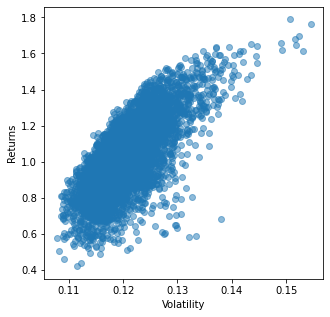

In [42]:
plt.figure(figsize = (5,5))
date = sorted(covariances.keys())[-1]
# plot efficient frontier
plt.scatter(x=portfolio_volatility[date],
            y=portfolio_returns[date],
            alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [43]:
# empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs, max_sharpe = {}, {}, {}
# loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
        volatility = portfolio_volatility[date][i]
        sharpe_ratio.setdefault(date,[]).append(ret / volatility)
    # get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])
    max_sharpe[date] = np.max(sharpe_ratio[date])

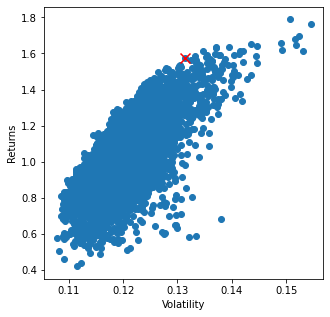

In [44]:
# latest date
plt.figure(figsize = (5,5))
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]
plt.scatter(x=cur_volatility,
            y=cur_returns)
best_idx = max_sharpe_idxs[date]
plt.scatter(cur_volatility[best_idx],
            cur_returns[best_idx],
            marker='x',
            s = 100,
            color='red')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [45]:
date = sorted(covariances.keys())
perfomance = pd.DataFrame(index = date)
perfomance['Returns'] = None
perfomance['Volatility'] = None
perfomance['Sharpe_ratio'] = None
for j in range(len(selected)):
        perfomance[D[selected].columns[j] + ' Weight'] = None
for i in range (len(date)):
    cur_returns = portfolio_returns[date[i]]
    cur_volatility = portfolio_volatility[date[i]]
    cur_weights = portfolio_weights[date[i]]
    best_idx = max_sharpe_idxs[date[i]]
    perfomance['Returns'][perfomance.index == date[i]] = cur_returns[best_idx]
    perfomance['Volatility'][perfomance.index == date[i]] = cur_volatility[best_idx]
    perfomance['Sharpe_ratio'][perfomance.index == date[i]] = max_sharpe[date[i]]
    for j in range(len(selected)):
        w = cur_weights[best_idx]
        perfomance[D[selected].columns[j] + ' Weight'][perfomance.index == date[i]] = w[j]
perfomance

,Returns,Volatility,Sharpe_ratio,BNB Weight,ADA Weight,ETC Weight,VET Weight,LINK Weight
2019-04-01,0.173174,0.0397348,4.35824,0.427289,0.189452,0.00513319,0.0335215,0.344604
2019-05-01,0.174046,0.04519,3.85143,0.272137,0.0147062,0.654004,0.0147345,0.0444178
2019-06-03,0.570587,0.0416044,13.7146,0.432898,0.0032211,0.494062,0.0199794,0.0498393
2019-07-01,2.54086,0.0604337,42.0438,0.0521272,0.0230596,0.0151715,0.0358801,0.873762
2019-08-01,-0.212447,0.0381741,-5.5652,0.409606,0.0157999,0.527969,0.042276,0.00434846
2019-09-02,0.00608103,0.0404322,0.150401,0.00454965,0.188207,0.685619,0.104382,0.0172423
2019-10-01,-0.0764993,0.0595534,-1.28455,0.0350514,0.0126276,0.11635,0.0214423,0.814529
2019-11-01,0.466608,0.0361085,12.9224,0.0110566,0.17416,0.000435491,0.0198766,0.794471
2019-12-02,0.570507,0.0481369,11.8518,0.0932459,0.0712621,0.0787115,0.704281,0.0524994
2020-01-01,0.0778703,0.0682257,1.14136,0.0862775,0.0874759,0.747502,0.0755638,0.00318098


### Часть 2

In [46]:
all_dates = C.index.unique()
all_symbols = D2.columns.unique()
df_MC = pd.DataFrame(index = all_dates)
for i in all_symbols:
    df_MC[i] = C['market_cap'].loc[C['symbol'] == i]
df_MC.index = pd.DatetimeIndex(df_MC.index)
df_MC

,BTC,BNB,LTC,ETH,NEO,QTUM,ADA,XRP,EOS,IOTA,...,BTT,ONG,HOT,ZIL,FET,ZRX,BAT,XMR,ZEC,IOST
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,5.384947e+12,1.963553e+10,2.911334e+11,1.726566e+12,1.168199e+11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,5.535933e+12,2.027370e+10,3.170348e+11,1.958591e+12,1.361219e+11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,5.977944e+12,2.065461e+10,3.204767e+11,2.035621e+12,1.447534e+11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,5.676073e+12,2.060430e+10,2.889483e+11,2.111199e+12,1.496947e+11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,6.363962e+12,2.808771e+10,3.159964e+11,2.279347e+12,1.540017e+11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,1.742472e+13,1.353735e+12,3.116684e+11,7.713555e+12,1.042299e+11,3.149277e+10,1.303561e+12,1.098347e+12,1.570239e+11,8.019112e+10,...,6.706524e+10,7.093548e+09,4.113765e+10,3.426142e+10,5.553645e+09,2.262910e+10,3.097327e+10,1.102731e+11,4.283482e+10,1.331146e+10
2021-05-28,1.644770e+13,1.251586e+12,2.890513e+11,7.117656e+12,9.639442e+10,2.972966e+10,1.195394e+12,1.005644e+12,1.446118e+11,7.274225e+10,...,6.154164e+10,7.720330e+09,3.637392e+10,3.019637e+10,5.065590e+09,2.045077e+10,2.766278e+10,1.050755e+11,4.234378e+10,1.226828e+10
2021-05-29,1.585517e+13,1.190503e+12,2.772481e+11,6.695159e+12,8.905259e+10,2.753438e+10,1.119152e+12,9.626525e+11,1.433293e+11,6.827916e+10,...,5.776928e+10,6.814551e+09,3.410102e+10,2.837427e+10,5.380800e+09,1.887528e+10,2.580027e+10,1.147029e+11,4.689668e+10,1.168984e+10


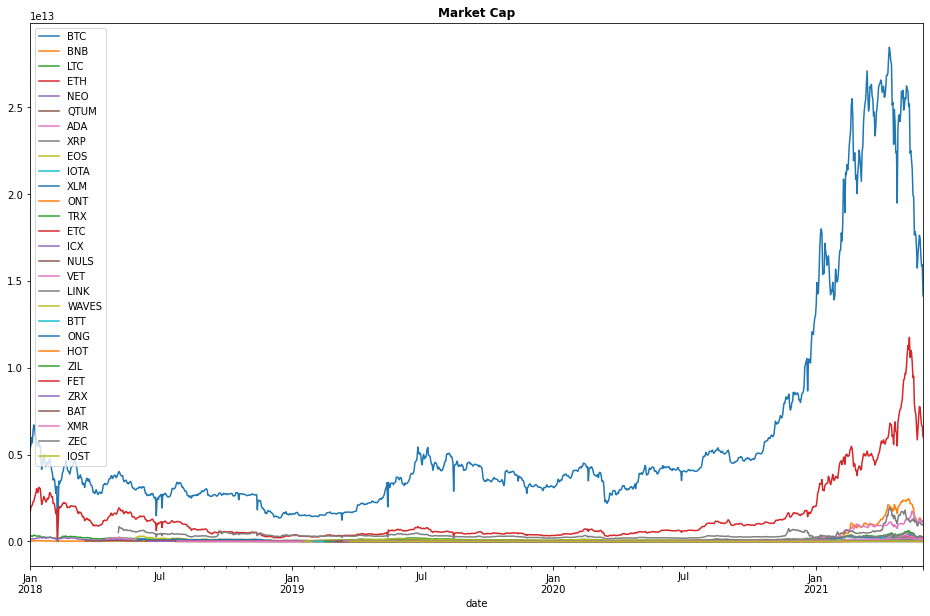

In [47]:
for i in D2.columns.unique():
    df_MC[i].plot(figsize=(16, 10))
plt.title("Market Cap", weight="bold")
plt.legend()
plt.show()

In [48]:
full_df = predicted_prices.copy()
full_df.index = pd.DatetimeIndex(full_df.index)
returns_daily = full_df.pct_change()

In [49]:
pd.options.display.max_rows = 800

Составим таблицу Perfomance, которая состоит из дневных доходностей портфеля

In [50]:
def portfolio_returns_daily(selected, selected_w, date):
    ret = 0
    i = 0
    for name in selected:
        ret += returns_daily[name][returns_daily.index == date][0] * selected_w[i]
        i += 1 
    return ret

In [51]:
def perfomance_table_of_daily_ret_1_2(selected, selected_w):
    date = returns_daily.index
    perfomance = pd.DataFrame(index = date)
    perfomance['Returns'] = None
    for j in range(len(selected)):
            perfomance[D[selected].columns[j] + ' Weight'] = selected_w[j]
    for i in range (len(date)):
        perfomance['Returns'][perfomance.index == date[i]] = portfolio_returns_daily(selected, selected_w, date[i])
    perfomance = perfomance.dropna(axis = 0)
    return perfomance

In [52]:
def perfomance_table_of_daily_ret_3():
    date = returns_daily.index
    perfomance = pd.DataFrame(index = date)
    perfomance['Returns'] = None
    selected_w = [0.1] * 10
    
    for date in returns_daily.index:
        X = df_MC.columns
        Y = df_MC[df_MC.index == date].values[0]
        sorted_names = [x for _,x in sorted(zip(Y,X))]
        selected = sorted_names[-10:]
        i = 0
        ret = 0
        for name in selected:
            ret += returns_daily[name][returns_daily.index == date][0] * selected_w[i]
            i += 1

        perfomance['Returns'][perfomance.index == date] = portfolio_returns_daily(selected, selected_w, date)

    perfomance = perfomance.dropna(axis = 0)
    return perfomance

In [53]:
def portfolio_returns_year(perfomance):
    ret = 1
    for t in range(len(perfomance.index)):
        ret *= (1 + perfomance['Returns'].iloc[t])
    ret = ret ** (365/len(perfomance.index))
    ret = ret - 1
    return ret

In [54]:
def volatility(perfomance):
    return perfomance['Returns'].std() * (365**0.5)

In [55]:
def Sharpe_ratio(perfomance):
    return (portfolio_returns_year(perfomance) - 0)/volatility(perfomance)

In [56]:
def Sortino_ratio(perfomance):
    negative_ret = perfomance['Returns'][perfomance['Returns'] < 0]
    neg_ret_volatility = negative_ret.std()
    return (portfolio_returns_year(perfomance) - 0)/neg_ret_volatility

In [57]:
def maximum_loss(perfomance):
    max_loss = 0
    current_loss = 0
    for i in range (len(perfomance.index)):
        if perfomance['Returns'].iloc[i] <= 0:
            current_loss += perfomance['Returns'].iloc[i]
        else:
            max_loss = min(max_loss, current_loss)
            current_loss = 0
    return max_loss

In [58]:
def print_result(type_of_p, portfolio_names):
    if type_of_p != 2: #вариант, когда криптовалюты в портфеле не меняются, то есть портфели 1 и 2
        perfomance = perfomance_table_of_daily_ret_1_2(selected, selected_w)
    else:
        perfomance = perfomance_table_of_daily_ret_3()
    print('Portfolio results for', portfolio_names[type_of_p])
    print('Среднегодовая доходность:', round(portfolio_returns_year(perfomance), 2))
    print('Показатель Шарпа:', round(Sharpe_ratio(perfomance), 2))
    print('Показатель Сортино:', round(Sortino_ratio(perfomance), 2))
    print('Максимальная просадка:', round(maximum_loss(perfomance)*100, 2), '%')
    print()

In [59]:
portfolio_names = ['Only BTC', 'BTC + ETH', '10 max Marketcaps']
for i in range(len(portfolio_names)):
    if i == 0:
        selected = ['BTC']
        selected_w = [1]
    elif i == 1:
        selected = ['BTC', 'ETH']
        selected_w = [0.5, 0.5]
    print_result(i, portfolio_names)

Portfolio results for Only BTC
Среднегодовая доходность: 1.78
Показатель Шарпа: 2.22
Показатель Сортино: 58.24
Максимальная просадка: -36.57 %

Portfolio results for BTC + ETH
Среднегодовая доходность: 2.41
Показатель Шарпа: 2.93
Показатель Сортино: 73.75
Максимальная просадка: -33.33 %

Portfolio results for 10 max Marketcaps
Среднегодовая доходность: 2.48
Показатель Шарпа: 2.79
Показатель Сортино: 68.97
Максимальная просадка: -42.47 %

